/Users/aaravdogra/work/citadel-datathon-2024/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-08-03 23:10:02,157] A new study created in memory with name: no-name-b0c34d6b-3f5e-4ddc-b9a3-0518548c3f2f
[I 2024-08-03 23:10:02,252] Trial 0 finished with value: 5.322705620544611 and parameters: {'n_estimators': 345, 'learning_rate': 0.1407800371313069, 'max_depth': 6, 'subsample': 0.9854550900835092, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 5.322705620544611.
[I 2024-08-03 23:10:02,328] Trial 1 finished with value: 3.0284019486603575 and parameters: {'n_estimators': 295, 'learning_rate': 0.1568143962971662, 'max_depth': 3, 'subsample': 0.9789932733184648, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 3.0284019486603575.
[I 2024-08-0

Best Parameters: {'n_estimators': 316, 'learning_rate': 0.15876210773206087, 'max_depth': 6, 'subsample': 0.9096690028031784, 'min_samples_split': 10, 'min_samples_leaf': 4}
Mean Squared Error with Gradient Boosting: 1.5576303454305065
R^2 Score with Gradient Boosting: 0.7020419642823988
                   Feature  Importance
0   Mean_Fruit_Consump_Pct    0.351329
5     Population_1_Percent    0.201237
4  Low_Income_Half_Percent    0.184625
2     Vehicle_Half_Percent    0.090288
3  Population_Half_Percent    0.088481
1  Mean_Veggie_Consump_Pct    0.084040


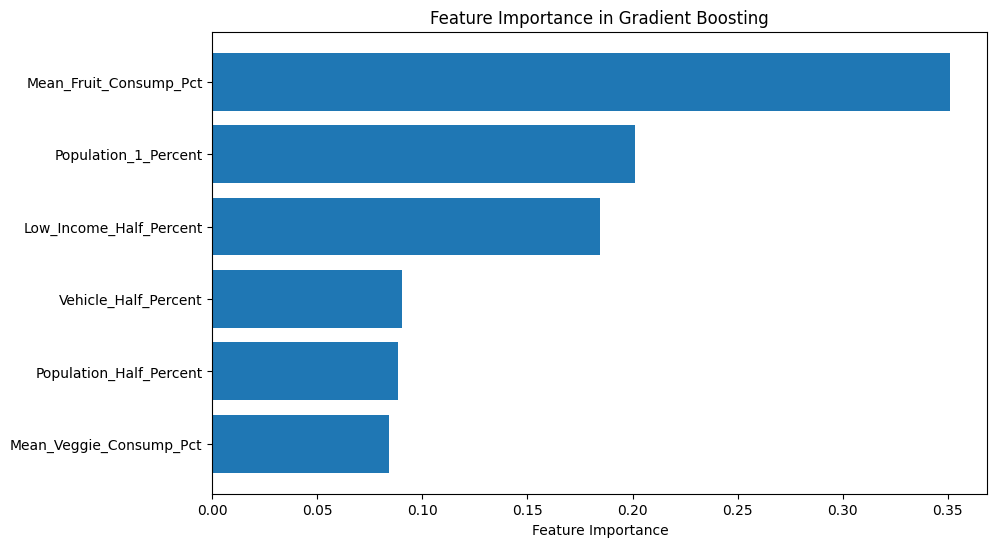

In [1]:
import optuna
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load and preprocess the data
df = pd.read_csv('../data/data-state-for-processing/merged_dataset.csv')
df = df.drop(columns=['State', 'Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0']).dropna()

# Select top features based on previous importance
top_features = ['Mean_Fruit_Consump_Pct', 'Mean_Veggie_Consump_Pct', 'Vehicle_Half_Percent',
                'Population_Half_Percent', 'Low_Income_Half_Percent', 'Population_1_Percent']
X = df[top_features]
y = df['Mean_Obesity_Pct']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    model = GradientBoostingRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create a study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
print(f"Best Parameters: {study.best_params}")

# Train the best model
best_params = study.best_params
best_gb = GradientBoostingRegressor(**best_params, random_state=42)
best_gb.fit(X_train, y_train)

# Predict and evaluate the best model
y_pred = best_gb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error with Gradient Boosting: {mse}")
print(f"R^2 Score with Gradient Boosting: {r2}")

# Feature importance
importances = best_gb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': top_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()

In [3]:
import joblib

model_filename = 'gradient-boosting-model.pkl'
joblib.dump(best_gb, model_filename)
print(f"Model saved as {model_filename}")

Model saved as gradient-boosting-model.pkl
